# **پیش بینی یک سهم از بازار تهران با کمک مدل‌های یادگیری عمیق**


---

در این پروژه هدف مقایسه و پیش‌بینی سهام‌های موجود در بازار بورس تهران است که با کمک یادگیری ماشین برای پیش‌بینی سری‌های زمانی صورت خواهد گرفت.

برای دریافت داده‌های بورس تهارن از کتابخانه *pytse client*
استفاده خواهد شد.

در ابتدای این پروژه در این نوت بوک،‌ کتابخانه‌های مورد نظر اضافه خواهند شد.
این کتابخانه‌ها به شرح زیر هستند:


1.   numpy
2.   pandas
3.   pytse  client
4.   sklearn
5.   keras
6.   tensorflow

In [ ]:
# unset proxy
%env http_proxy=
%env https_proxy=

!apt -qq update
!apt -qq full-upgrade -y
!pip install numpy pandas pytse-client sklearn keras tensorflow

پس از نصب کتابخانه‌های مد نظر در ابتدا داده‌های سهام دلخواه را با کمک کتابخانه pyste-client استخراج می‌کنیم. برای مثال سهام «فملی» را نمایش خواهیم داد.

In [ ]:
# import pytse_client as tse
# # download tickers
# tickers = tse.download(symbols="وبملت", write_to_csv=True)
# print(tickers["وبملت"])

یکی از مهمترین مشکلات این کتابخانه در گوگل کولب، عدم دانلود فایل‌هاست، (حتی با قرار دادن پروکسی این مشکل قابل حل نیست) به همین دلیل لازم است فایل مورد نظر به صورت دستی دانلود شده و سپس در اینجا آپلود شود. با این روش می‌توان با کمک کتابخانه pandas به فایل مربوطه دسترسی داشت.

لازم به ذکر است به دلیل مشکلات دسترسی wget هم کار نخواهد کرد. به همین منظور از tor به عنوان پروکسی رایگان در این بخش استفاده شده است.

In [ ]:
# # unset proxy
# %env http_proxy=
# %env https_proxy=

# # install tor
# !apt install tor privoxy
# !echo "ExitNodes {IR}" > /etc/tor/torrc
# !echo "UseBridges 0" >> /etc/tor/torrc
# !echo "SocksListenAddress 127.0.0.1:9050" >> /etc/tor/torrc
# !echo "SocksPort 9050" >> /etc/tor/torrc
# !echo "forward-socks5 / localhost:9050 ." > /etc/privoxy/config
# !echo "listen-address  127.0.0.1:8118 ." >> /etc/privoxy/config
# !echo "********************************************"
# !echo "***************** Tor Config ***************"
# !cat /etc/tor/torrc
# !echo "********************************************"
# !echo "*************** Privoxy Config *************"
# !cat /etc/privoxy/config
# !echo "********************************************"
# !echo "********************************************"
# !privoxy /etc/privoxy/config


In [ ]:
# run tor
# import subprocess
# subprocess.Popen(["tor"])

# setup proxy
# %env http_proxy=127.0.0.1:8118

# !wget -O 'S_Mellat.Bank.csv' 'http://old.tsetmc.com/tsev2/data/Export-txt.aspx?t=i&a=1&b=0&i=778253364357513'

# unset proxy
# %env http_proxy=

# GPU Test
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# read file
import pandas as pd
data = pd.read_csv("S_Mellat.Bank.csv")
print(data)

در این پروژه هدف پیشبینی بیشترین ارزش یک سهام در طول روز است.

از آنجا که داده‌ها دارای نمونه برداری مرتبی نیستند میبایست روشی متفاوت را برای پیش‌بینی درنظر گرفت. در اینجا ورودی را علاوه بر داده‌ها فاصله بین داده فعلی و قبلی نیز قرار میدهیم. این موضوع به ماشین کمک میکند تغییرات بزرگ را در مقادیر بهتر درک کند.

In [4]:
data1 = data[['<HIGH>']].to_numpy()
time1 = data[['<DTYYYYMMDD>']].to_numpy()

import numpy as np
data1 = np.flipud(data1) # older data be at first
time1 = np.flipud(time1) # reorder time
data1 = np.delete(data1 , np.s_[2300:2900] , 0) # bad data for وبملت
time1 = np.delete(time1 , np.s_[2300:2900] , 0) # bad times for وبملت
temp_data2 = np.diff(data1 , axis=0)
time2 = np.diff(time1 , axis=0)
data2 = data1[:-1]
newtime1 = time1[:-1]

در فرایند یادگیری ماشین برای پیش‌بینی قیمت سهام، برای ارزیابی دقت الگوریتم‌های یادگیری، داده‌ها را به سه بخش تقسیم می‌کنیم: بخش یادگیری، بخش تست و بخش صحت سنجی.

در بخش یادگیری، مدل را با استفاده از داده‌های قیمت سهام آموزش می‌دهیم. در این بخش، ماشین از داده‌های قبلی یاد می‌گیرد و با استفاده از الگوریتم‌های یادگیری، تلاش می‌کند قیمت سهام در زمان بعدی را پیش‌بینی کند.

در بخش تست، ما از مدلی که در بخش یادگیری آموزش دادیم، برای پیش‌بینی قیمت سهام در زمان‌های جدید استفاده می‌کنیم. برای این کار، داده‌هایی که قبلا در بخش یادگیری به ماشین داده شده بودند، حذف می‌شوند و ماشین از داده‌هایی که تاکنون ندیده است، برای پیش‌بینی استفاده می‌کند.

در بخش صحت سنجی، با استفاده از داده‌هایی که در بخش تست استفاده نشده بودند، دقت پیش‌بینی مدل را بررسی می‌کنیم. به عنوان مثال، با استفاده از معیارهایی مانند دقت (Accuracy)، صحت (Precision) و بازخوانی (Recall)، ارزیابی می‌کنیم که مدل به چه میزان در پیش‌بینی قیمت سهام موفق بوده است.

در کل، تقسیم داده‌ها به سه بخش یادگیری، تست و صحت سنجی، برای ارزیابی دقت مدل در پیش‌بینی قیمت سهام بسیار مهم است و این امر به ما کمک می‌کند تا مطمئن شویم که مدلی که آموزش داده‌ایم، قابل اعتماد و دقیق است.

In [5]:
n1 = int(data2.shape[0] * 0.75) # 75% train
n2 = int((data2.shape[0] - n1)/2) # 12.5% test and other for validation
x_train = data2[:n1 , :]
x_val = data2[n1: n1 + n2 , :]
x_test = data2[n1 + n2: , :]
t_train = newtime1[:n1 , :]
t_val = newtime1[n1: n1 + n2 , :]
t_test = newtime1[n1 + n2:, :]
dt_train = time2[:n1 , :]
dt_val = time2[n1: n1 + n2 , :]
dt_test = time2[n1 + n2:, :]

در فرایند پیش‌بینی قیمت سهام، در بسیاری از موارد داده‌ها ممکن است با مقیاس‌های مختلفی ذخیره شوند. برای مثال، بازدهی سهام در یک بازه زمانی ممکن است از دسته‌ی ۰ تا ۱۰ درصد باشد، در حالی که فاصله‌ی زمانی بین دو تاریخ ممکن است از یک هفته تا چند سال باشد. بنابراین، قبل از استفاده از داده‌ها برای آموزش مدل، باید داده‌ها را به یک مقیاس مشترک تبدیل کنیم. به این فرایند، استاندارد سازی گفته می‌شود.

یکی از روش‌های استاندارد سازی، روش MinMaxScaler است که در کتابخانه‌ی sklearn موجود است. با استفاده از این روش، داده‌ها به گونه‌ای تبدیل می‌شوند که همه در بازه‌ی ۰ تا ۱ قرار می‌گیرند. این روش به این صورت است که برای هر متغیر، مقادیر آن را تقسیم بر بیشترین مقدار آن متغیر در داده‌ها می‌کنیم. سپس، از مقدار حاصل، کمترین مقدار آن متغیر را کم می‌کنیم. در نهایت، مقادیر تبدیل شده‌ی هر متغیر در بازه‌ی ۰ تا ۱ قرار می‌گیرد.

با استفاده از روش MinMaxScaler، داده‌ها به یک مقیاس مشترک تبدیل می‌شوند و می‌توانیم از آن‌ها برای آموزش مدل استفاده کنیم. با این کار، دقت مدل در پیش‌بینی قیمت سهام بهبود پیدا می‌کند و می‌توانیم اطمینان داشته باشیم که مدل ما قادر به پیش‌بینی قیمت سهام با دقت بالاست.

In [6]:
from sklearn import preprocessing

minmax_scale = preprocessing.MinMaxScaler().fit(x_train)
x_train_n = minmax_scale.transform(x_train)
x_val_n = minmax_scale.transform(x_val)
x_test_n = minmax_scale.transform(x_test)

در فرایند پیش‌بینی قیمت سهام با استفاده از شبکه‌های عصبی، باید داده‌ها را به گونه‌ای مرتب کرد که بتوانیم آن‌ها را به عنوان ورودی و خروجی به شبکه‌ی عصبی بدهیم. برای این کار، می‌توانیم داده‌ها را بر اساس درجه‌ی دلخواهی که می‌خواهیم پیش‌بینی کنیم، مرتب کنیم.

برای مثال، اگر می‌خواهیم قیمت سهام را برای یک روز آینده پیش‌بینی کنیم، می‌توانیم قیمت سهام را بر اساس تاریخ به ترتیب صعودی مرتب کنیم. به این صورت که ابتدا داده‌هایی مربوط به تاریخ‌های گذشته را به شبکه‌ی عصبی می‌دهیم و خروجی شبکه را بر اساس تاریخ بعدی پیش‌بینی می‌کنیم.

همچنین، برای این که شبکه‌ی عصبی بتواند با داده‌های مرتب کار کند، باید داده‌ها را به صورت دنباله‌ای مرتب کنیم. به عنوان مثال، می‌توانیم برای پیش‌بینی قیمت سهام در روز بعد، داده‌های قیمت سهام را به صورت دنباله‌ای به شبکه‌ی عصبی بدهیم. به این صورت که داده‌های قیمت سهام را برای تاریخ‌های گذشته به صورت دنباله‌ای مرتب کرده و به عنوان ورودی به شبکه‌ی عصبی می‌دهیم. سپس، خروجی شبکه را برای تاریخ بعدی پیش‌بینی می‌کنیم.

در کل، برای پیش‌بینی قیمت سهام با استفاده از شبکه‌های عصبی، باید داده‌ها را به گونه‌ای مرتب کرد که بتوانیم آن‌ها را به عنوان ورودی و خروجی به شبکه‌ی عصبی بدهیم. به همین دلیل، نیاز است داده‌ها را به صورت دنباله‌ای مرتب کنیم و بر اساس درجه دلخواه بازنویسی کنیم.

In [7]:
def Data_Initializer(t , x , deg):
  tmp = [x[i  : i + deg , 0] for i in range(len(x) - deg)]
  for i in range(len(tmp)):
    tmp[i] = np.insert(tmp[i] , 0 , t[i])
  x_train = np.array(tmp)
  y_train = x[deg : , :]
  return x_train , y_train

n = 12 # deg
x_train_final , y_train_final = Data_Initializer(dt_train , x_train_n , n)
x_test_final , y_test_final = Data_Initializer(dt_test , x_test_n , n)
x_val_final , y_val_final = Data_Initializer(dt_val , x_val_n , n)



---


# تعریف مدل LSTM

در فرایند پیش‌بینی قیمت سهام با استفاده از شبکه‌های عصبی، باید شبکه‌ی عصبی را به گونه‌ای تعریف کنیم که بتوانیم برای آموزش از آن استفاده کنیم. در این بخش، یک شبکه‌ی عصبی ساده با استفاده از تنسورفلو 2 و کراس تعریف می‌کنیم.

ابتدا، برای تعریف شبکه‌ی عصبی، لایه‌های مختلف را به کمک کتابخانه‌ی کراس تعریف می‌کنیم. برای مثال، می‌توانیم از 2 لایه‌ی LSTM و 2 لایه‌ی Dense استفاده کنیم. همچنین، برای بهینه‌سازی شبکه از الگوریتم Adam و اتلاف MSE استفاده می‌کنیم. نرخ یادگیری نیز برابر با 0.001 در نظر گرفته می‌شود. برای این کار، کد زیر را می‌توان به کار برد:

In [8]:
import numpy as np
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
np.random.seed(10)
import tensorflow
tensorflow.random.set_seed(12)

lstm_input = Input(shape=(n+1,1), name='lstm_input')
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='dropout_0')(x)
x = Dense(120, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)
model = Model(inputs=lstm_input, outputs=output)

adam = optimizers.Adam(lr=0.001)

model.compile(optimizer=adam, loss='mse', metrics=['accuracy' , tf.keras.metrics.RootMeanSquaredError()])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


این کد به صورت یک شبکه‌ی عصبی ساده با استفاده از تنسورفلو تعریف می‌کند که از یک لایه‌ی LSTM، دو لایه‌ی Dense و دو فعال‌سازی استفاده می‌کند.

ابتدا یک ورودی با نام lstm_input با شکل (n+1, 1) تعریف شده است. این ورودی برای تعریف لایه‌ی LSTM به کار می‌رود. در خط بعدی، یک لایه‌ی LSTM با ۵۰ واحد خروجی و نام lstm_0 تعریف شده است. ورودی این لایه، لایه‌ی lstm_input است.

در خط بعدی، با استفاده از Dropout، ۲۰ درصد از واحدهای خروجی لایه‌ی LSTM را رها می‌کنیم. این کار به منظور جلوگیری از برازش بیش از حد مدل به داده‌های آموزشی است.

سپس با استفاده از یک لایه‌ی Dense با ۱۲۰ واحد خروجی و نام dense_0، ورودی لایه‌ی LSTM را به یک فضای ویژگی با بعد کمتر تبدیل می‌کنیم. فعال‌سازی sigmoid نیز در این لایه استفاده شده است.

در خط بعدی، یک لایه‌ی Dense با ۱ واحد خروجی و نام dense_1 تعریف شده است. ورودی این لایه، خروجی لایه‌ی Dense قبلی است.

در نهایت، با استفاده از فعال‌سازی linear، خروجی لایه‌ی Dense آخر به عنوان خروجی کلی شبکه تعریف شده است. این خروجی با نام linear_output در مدل تعریف شده است.

در انتها، با استفاده از تابع Model و با دادن ورودی و خروجی به عنوان پارامترهای این تابع، یک شبکه‌ی عصبی با نام model تعریف شده است. با استفاده از این شبکه، می‌توانیم به پیش‌بینی قیمت سهام بپردازیم.

# ترسیم ساختار مدل

در فرایند پیش‌بینی قیمت سهام با استفاده از شبکه‌های عصبی، بسیار مهم است که بتوانیم ساختار مدل را به صورت گرافیکی نمایش دهیم تا بتوانیم بهتر درک کنیم که هر لایه از شبکه‌ی عصبی چه کاری انجام می‌دهد. در اینجا، به ترسیم ساختار مدل پیش‌بینی قیمت سهام با استفاده از شبکه‌های عصبی می‌پردازیم.

برای ترسیم ساختار مدل، می‌توانیم از کتابخانه‌ی کراس و تابع plot_model آن استفاده کنیم. این تابع، یک گرافیک از ساختار مدل را با استفاده از شکل‌های هندسی مختلف نشان می‌دهد.

 از کد زیر برای ترسیم ساختار مدل پیش‌بینی قیمت سهام استفاده کنیم:

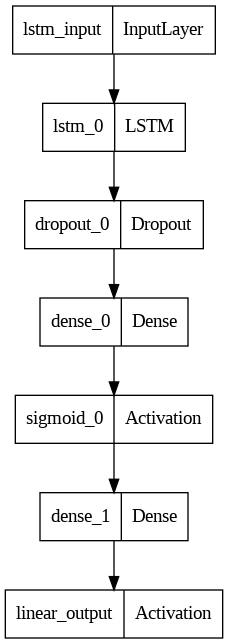

In [ ]:
from keras.utils import plot_model
plot_model(model)

این کد برای آموزش مدل شبکه‌ی عصبی LSTM بر روی داده‌های آموزشی و ارزیابی آن بر روی داده‌های اعتبارسنجی، با استفاده از کتابخانه‌ی کراس و تابع fit تعریف شده است.

در این کد، از کلاس ModelCheckpoint کتابخانه‌ی کراس استفاده شده است. این کلاس به منظور ذخیره‌ی بهترین مدل بر اساس معیاری که در پارامتر monitor تعیین شده است، تعریف شده است. در اینجا، بهترین مدل بر اساس معیار val_loss که نشان دهنده‌ی خطای مدل در اعتبارسنجی است، ذخیره می‌شود. فایل مدل ذخیره شده با نام LSTM_model.h5 در مسیر فعلی ذخیره می‌شود.

سپس با استفاده از تابع fit، مدل با داده‌های آموزشی آموزش داده می‌شود. در این تابع، به ترتیب داده‌های ورودی x_train_final و y_train_final به عنوان داده‌های آموزشی و داده‌های ورودی x_val_final و y_val_final به عنوان داده‌های اعتبارسنجی به مدل داده می‌شود. با استفاده از پارامتر batch_size، بلوک‌هایی از داده‌های آموزشی به مدل داده می‌شود. با تعیین پارامتر epochs، تعداد دوره‌های آموزش مشخص می‌شود. همچنین، با تعیین پارامتر shuffle=True، داده‌ها قبل از دادن به مدل به صورت تصادفی مرتب می‌شوند.

در نهایت، با دادن لیستی از callbackها به پارامتر callbacks، کلاس ModelCheckpoint به تابع fit داده می‌شود تا بهترین مدل ذخیره شود. در اینجا، تنها callback استفاده شده ModelCheckpoint است. با اجرای این کد، مدل LSTM آموزش داده می‌شود و بهترین مدل بر اساس معیار val_loss ذخیره می‌شود. همچنین، تاریخچه‌ی آموزش مدل در متغیر history ذخیره می‌شود.

در این یادگیری پارامترها به شرح زیر است:

*   batch_size=32
*   epochs=200

In [ ]:
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('./LSTM_model.h5', save_best_only=True, monitor='val_loss', mode='min')
history = model.fit(x=x_train_final, y=y_train_final, batch_size=32, epochs=200, shuffle=True, validation_data=(x_val_final, y_val_final), callbacks=[mcp_save])

تا اینجا شبکه را با داده‌های آموزشی که آماده شده بود، آموزش دید. حالا باید بررسی شود که این شبکه روی داده‌های تست چه عملکردی دارد. به این منظور ابتدا مدل ذخیره شده فراخوانی می‌شود. سپس داده‌های تست به مدل داده می‌شود.

In [9]:
model.load_weights('./LSTM_model.h5')
evaluation = model.evaluate(x_test_final, y_test_final)
print(evaluation)

10/10 [==============================] - 1s 4ms/step - loss: 0.0250 - accuracy: 0.0000e+00 - root_mean_squared_error: 0.1582
[0.025028351694345474, 0.0, 0.15820351243019104]


این عدد scale شده است و باید ایم مقدار MSE به مقدار واقعی داده‌ها بازگردد. ابتدا داده‌ها را از حالت نرمال شده خارج میکنیم.

حال مقادیر پیش‌بینی شده توسط شبکه را با استفاده از scale_back به رنج واقعی تغییر می‌دهیم. سپس مقدار اتلاف را برای داده‌های تست محاسبه می‌کنیم:

In [10]:
y_train_real = np.array([x_train[i + n] for i in range(len(x_train) - n)])
scale_back = preprocessing.MinMaxScaler().fit(y_train_real)
y_test_predicted = model.predict(x_test_final)
y_test_predicted = scale_back.inverse_transform(y_test_predicted)
y_test_real = scale_back.inverse_transform(y_test_final)
real_mse = np.mean(np.square(y_test_real - y_test_predicted))
print(real_mse)

10/10 [==============================] - 0s 3ms/step
129993.27791694271


برای بررسی بهتر رفتار شبکه حاصل شبکه و مقدار واقعی روی هم به نمایش در آمده است.

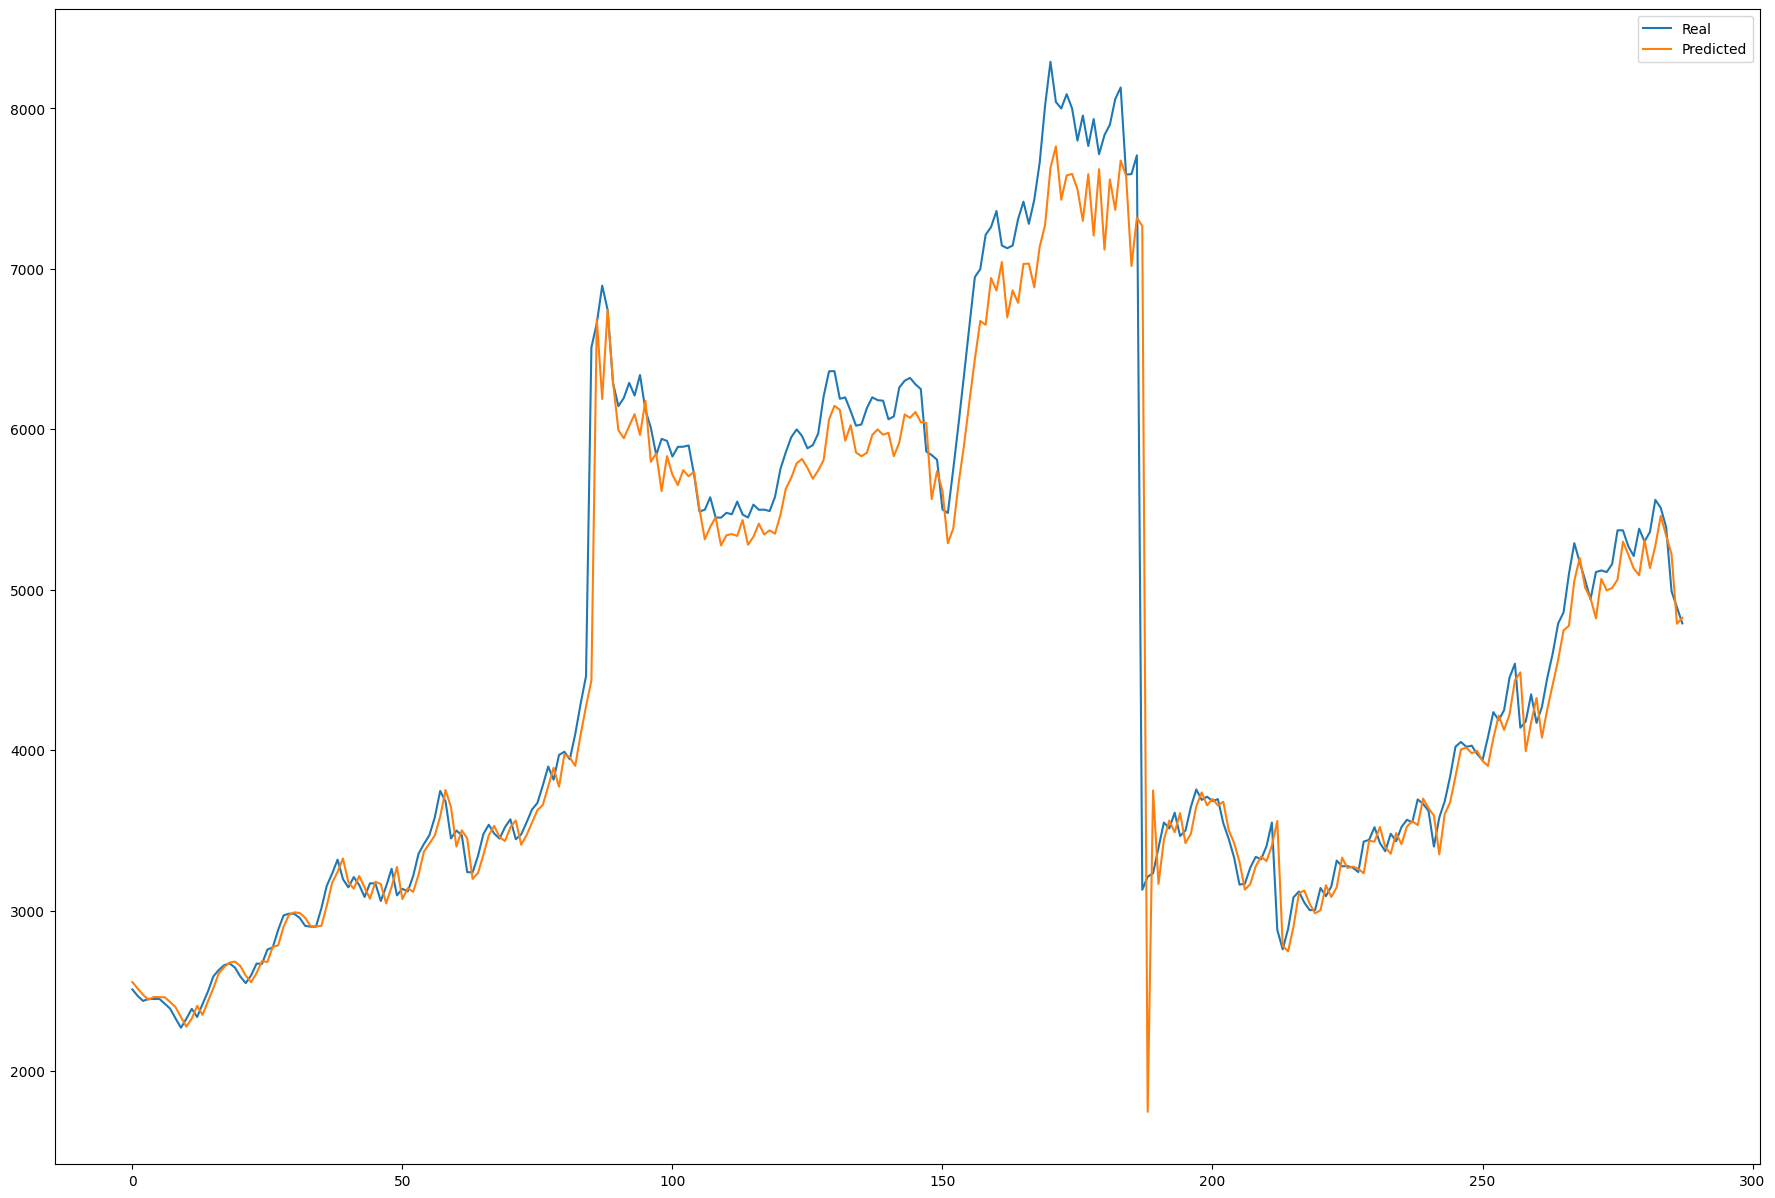

In [11]:
import matplotlib.pyplot as plt
plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(y_test_real[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])

plt.show()

این کد برای رسم نمودار پیش‌بینی واقعی برای داده‌های تست استفاده می‌شود.

ابتدا با استفاده از کتابخانه‌ی matplotlib، اندازه‌ی نمودار تعیین می‌شود. با استفاده از تابع gcf()، شیء شکل فعلی به عنوان شیء اصلی مورد استفاده قرار می‌گیرد. با استفاده از تابع set_size_inches()، اندازه‌ی نمودار تعیین می‌شود.

سپس با تعیین بازه‌ی start و end، داده‌های واقعی و پیش‌بینی شده برای نمایش در نمودار انتخاب می‌شوند.

سپس با استفاده از تابع plot، دو مجموعه داده‌ی رسم می‌شوند. مجموعه‌ی اول واقعی و مجموعه‌ی دوم پیش‌بینی شده است. هر دو مجموعه داده با استفاده از تابع plot رسم می‌شوند. نام هر کدام از دو مجموعه با استفاده از پارامتر label مشخص شده است.

در خط بعدی، با استفاده از تابع legend، برای نمودار عنوان‌هایی با نام‌های Real و Predicted تعریف شده است.

در نهایت، با استفاده از تابع show()، نمودار رسم شده نمایش داده می‌شود.

---



# شبکه RNN

در ادامه، کد زیر یک شبکه عصبی ساده با استفاده از کتابخانه کراس تعریف می‌کند. این شبکه شامل یک لایه SimpleRNN، دو لایه Dense و سه فعال‌سازی است.

ابتدا با استفاده از تابع Input، یک ورودی با نام input و شکل (n+1, 1) تعریف شده است. سپس با استفاده از تابع SimpleRNN، یک لایه RNN با ۵۰ واحد خروجی و نام RNN_0 تعریف شده است. ورودی این لایه، لایه input است.

در خط بعدی، با استفاده از Dropout، ۲۰ درصد از واحدهای خروجی لایه RNN را رها می‌کنیم. این کار به منظور جلوگیری از برازش بیش از حد مدل به داده‌های آموزشی است.

سپس با استفاده از یک لایه‌ی Dense با ۱۲۰ واحد خروجی و نام dense_1، ورودی لایه RNN را به یک فضای ویژگی با بعد کمتر تبدیل می‌کنیم. فعال‌سازی sigmoid نیز در این لایه استفاده شده است.

در خط بعدی، یک لایه‌ی Dense با ۱ واحد خروجی و نام dense_2 تعریف شده است. ورودی این لایه، خروجی لایه‌ی Dense قبلی است.

در نهایت، با استفاده از فعال‌سازی linear، خروجی لایه‌ی Dense آخر به عنوان خروجی کلی شبکه تعریف شده است. این خروجی با نام linear_output در مدل تعریف شده است.

در انتها، با استفاده از تابع Model و با دادن ورودی و خروجی به عنوان پارامترهای این تابع، یک شبکه‌ی عصبی با نام model تعریف شده است. با استفاده از این شبکه، می‌توانیم به پیش‌بینی قیمت سهام بپردازیم.

In [12]:
import numpy as np
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, SimpleRNN, Input, Activation, concatenate
from keras import optimizers
np.random.seed(10)
import tensorflow
tensorflow.random.set_seed(12)

input = Input(shape=(n+1,1), name='input')
x = SimpleRNN(50, name='RNN_0')(input)
x = Dropout(0.2, name='dropout_0')(x)
x = Dense(120, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)
model = Model(inputs=input, outputs=output)

adam = optimizers.Adam(lr=0.001)

model.compile(optimizer=adam, loss='mse', metrics=['accuracy' , tf.keras.metrics.RootMeanSquaredError()])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# ترسیم ساختار مدل

همانند قبل برای درک بهتر مدل را ترسیم میکنیم.

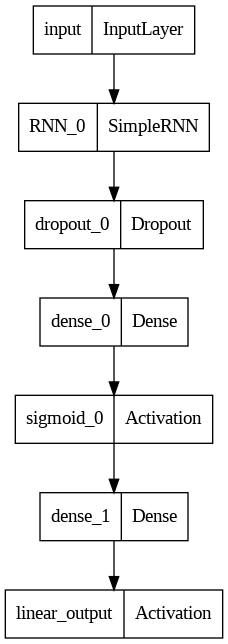

In [ ]:
from keras.utils import plot_model
plot_model(model)

در اینجا با ثبت اجازه شافل داده، یادگیری را شروع میکنیم.

در این یادگیری پارامترها به شرح زیر است:

*   batch_size=32
*   epochs=200

In [ ]:
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('./RNN_model.h5', save_best_only=True, monitor='val_loss', mode='min')
history = model.fit(x=x_train_final, y=y_train_final, batch_size=32, epochs=200, shuffle=True, validation_data=(x_val_final, y_val_final), callbacks=[mcp_save])

In [13]:
model.load_weights('./RNN_model.h5')
evaluation = model.evaluate(x_test_final, y_test_final)
print(evaluation)

10/10 [==============================] - 0s 3ms/step - loss: 0.0659 - accuracy: 0.0035 - root_mean_squared_error: 0.2567    
[0.06587328016757965, 0.0034602077212184668, 0.2566578984260559]


این عدد scale شده است و باید ایم مقدار MSE به مقدار واقعی داده‌ها بازگردد. ابتدا داده‌ها را از حالت نرمال شده خارج میکنیم.

حال مقادیر پیش‌بینی شده توسط شبکه را با استفاده از scale_back به رنج واقعی تغییر می‌دهیم. سپس مقدار اتلاف را برای داده‌های تست محاسبه می‌کنیم:

In [14]:
y_train_real = np.array([x_train[i + n] for i in range(len(x_train) - n)])
scale_back = preprocessing.MinMaxScaler().fit(y_train_real)
y_test_predicted = model.predict(x_test_final)
y_test_predicted = scale_back.inverse_transform(y_test_predicted)
y_test_real = scale_back.inverse_transform(y_test_final)
real_mse = np.mean(np.square(y_test_real - y_test_predicted))
print(real_mse)

10/10 [==============================] - 0s 4ms/step
342135.28274725756


برای بررسی بهتر رفتار شبکه حاصل شبکه و مقدار واقعی روی هم به نمایش در آمده است.

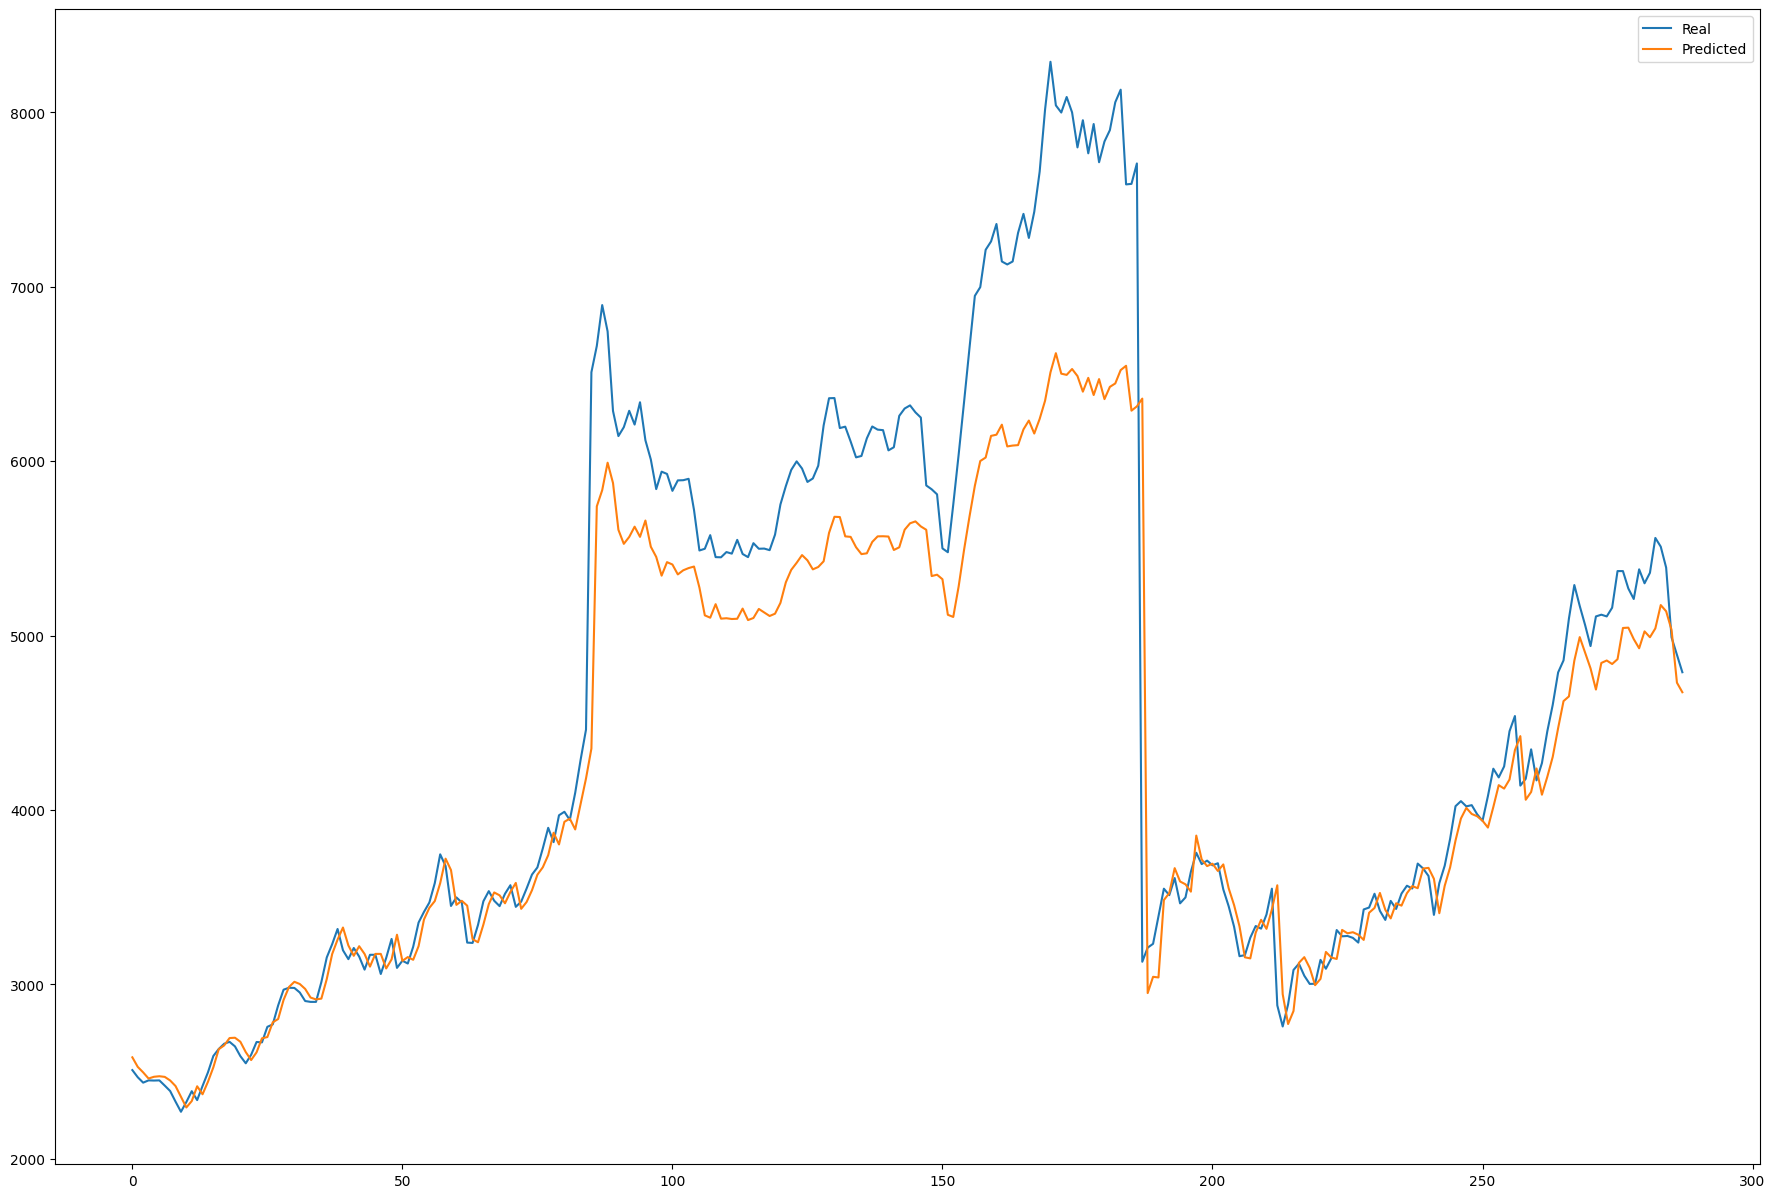

In [15]:
import matplotlib.pyplot as plt
plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(y_test_real[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])

plt.show()



---

# شبکه GRU

شبکه‌ی GRU (Gated Recurrent Unit) یک نوع از شبکه‌های عصبی بازگشتی (RNN) است که برای پردازش داده‌های دنباله‌ای استفاده می‌شود.

شبکه‌های بازگشتی به علت داشتن حلقه‌ی بازگشتی می‌توانند اطلاعات قبلی را در خود حفظ کنند و در هنگام پردازش داده‌های دنباله‌ای، اطلاعات قبلی را با داده‌های جدید ترکیب کنند. اما یکی از مشکلات این شبکه‌ها، مشکل ناپدید شدن گرادیان (Vanishing Gradient) است که در آن گرادیان‌های مربوط به داده‌های قدیمی در طول زمان به صفر میل می‌کنند و این باعث می‌شود که شبکه نتواند به خوبی اطلاعات قبلی را در پردازش داده‌های جدید استفاده کند.

برای حل این مشکل، شبکه‌های GRU از یک ساختار دروازه‌ای (gating mechanism) استفاده می‌کنند که باعث می‌شود که شبکه توانایی یادگیری و حفظ اطلاعات ضروری را در طول زمان داشته باشد. در واقع، شبکه GRU از دو دروازه‌ی (gates) آموزش‌دیده شده به نام‌های "دروازه باز شدن" (update gate) و "دروازه حذف" (reset gate) استفاده می‌کند که با کنترل جریان اطلاعات، می‌تواند از ناپدید شدن گرادیان جلوگیری کند.

دروازه باز شدن باعث می‌شود که شبکه تصمیم بگیرد که چه میزان اطلاعات جدید را به حافظه‌ی خود اضافه کند. دروازه حذف هم باعث می‌شود که شبکه تصمیم بگیرد که چه میزان اطلاعات قبلی را نادیده بگیرد و فقط از اطلاعات جدید استفاده کند. این دو دروازه به همراه یک واحد حافظه (memory cell) و یک واحد خروجی (output unit) در شبکه GRU وجود دارند و با کنترل جریان اطلاعات، می‌تواند از ناپدید شدن گرادیان جلوگیری کند و به خوبی اطلاعات قبلی را در پردازش داده‌های جدید استفاده کند.

In [16]:
import numpy as np
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, GRU, Input, Activation, concatenate
from keras import optimizers
np.random.seed(10)
import tensorflow
tensorflow.random.set_seed(12)

input = Input(shape=(n+1,1), name='input')
x = GRU(50, name='GRU_0')(input)
x = Dropout(0.2, name='dropout_0')(x)
x = Dense(120, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)
model = Model(inputs=input, outputs=output)

adam = optimizers.Adam(lr=0.001)

model.compile(optimizer=adam, loss='mse', metrics=['accuracy' , tf.keras.metrics.RootMeanSquaredError()])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


این کد یک مدل شبکه‌ی عصبی بازگشتی GRU برای پیش‌بینی یک مقدار عددی از یک دنباله‌ی زمانی را تعریف می‌کند.

در این کد، با استفاده از تابع Input از کتابخانه‌ی Keras یک لایه‌ی ورودی به مدل اضافه می‌شود که شامل یک دنباله‌ی زمانی با طول n+1 و یک کانال است.

سپس، یک لایه‌ی GRU با 50 واحد حافظه (GRU(50)) به مدل اضافه می‌شود که این لایه با اطلاعات ورودی کار می‌کند و اطلاعات را در قالب واحدهای حافظه در خود ذخیره می‌کند.

سپس با اضافه کردن لایه‌ی Dropout با نرخ 0.2 به مدل، به منظور جلوگیری از برازش بیش از حد (overfitting)، تعدادی از واحدهای خروجی لایه‌ی GRU با احتمال 0.2 غیرفعال شده و از محاسبات خارج می‌شوند.

سپس با اضافه کردن یک لایه‌ی Dense با 120 واحد به مدل، از واحدهای خروجی لایه‌ی قبلی استفاده شده و از آن‌ها برای پیش‌بینی مقدار عددی استفاده می‌شود و با استفاده از تابع فعال‌سازی sigmoid، خروجی لایه‌ی Dense به مقادیر بین 0 و 1 نرمالیزه می‌شود.

سپس با اضافه کردن یک لایه‌ی Dense با 1 واحد به مدل، از واحدهای خروجی لایه‌ی قبلی استفاده شده و برای پیش‌بینی مقدار عددی نهایی استفاده می‌شود و با استفاده از تابع فعال‌سازی linear، خروجی لایه‌ی Dense به صورت خطی تبدیل می‌شود.

در نهایت با استفاده از تابع Model از کتابخانه‌ی Keras، مدل نهایی با ورودی‌های input و خروجی output تعریف شده و برای آموزش و پیش‌بینی استفاده می‌شود.

# ترسیم ساختار مدل

همانند قبل برای درک بهتر مدل را ترسیم میکنیم.

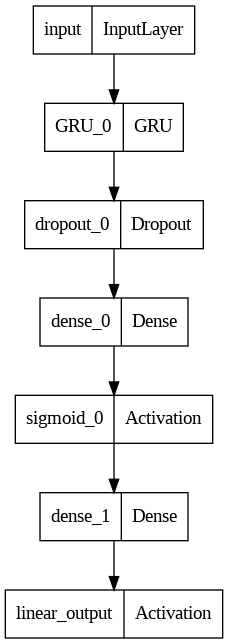

In [ ]:
from keras.utils import plot_model
plot_model(model)

در اینجا با ثبت اجازه شافل داده، یادگیری را شروع میکنیم.

در این یادگیری پارامترها به شرح زیر است:

*   batch_size=32
*   epochs=200

In [ ]:
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('./GRU_model.h5', save_best_only=True, monitor='val_loss', mode='min')
history = model.fit(x=x_train_final, y=y_train_final, batch_size=32, epochs=200, shuffle=True, validation_data=(x_val_final, y_val_final), callbacks=[mcp_save])

In [17]:
model.load_weights('./GRU_model.h5')
evaluation = model.evaluate(x_test_final, y_test_final)
print(evaluation)

10/10 [==============================] - 1s 4ms/step - loss: 0.0289 - accuracy: 0.0035 - root_mean_squared_error: 0.1699    
[0.028853964060544968, 0.0034602077212184668, 0.16986455023288727]


این عدد scale شده است و باید ایم مقدار MSE به مقدار واقعی داده‌ها بازگردد. ابتدا داده‌ها را از حالت نرمال شده خارج میکنیم.

حال مقادیر پیش‌بینی شده توسط شبکه را با استفاده از scale_back به رنج واقعی تغییر می‌دهیم. سپس مقدار اتلاف را برای داده‌های تست محاسبه می‌کنیم:

In [18]:
y_train_real = np.array([x_train[i + n] for i in range(len(x_train) - n)])
scale_back = preprocessing.MinMaxScaler().fit(y_train_real)
y_test_predicted = model.predict(x_test_final)
y_test_predicted = scale_back.inverse_transform(y_test_predicted)
y_test_real = scale_back.inverse_transform(y_test_final)
real_mse = np.mean(np.square(y_test_real - y_test_predicted))
print(real_mse)

10/10 [==============================] - 0s 3ms/step
149862.95597771418


برای بررسی بهتر رفتار شبکه حاصل شبکه و مقدار واقعی روی هم به نمایش در آمده است.

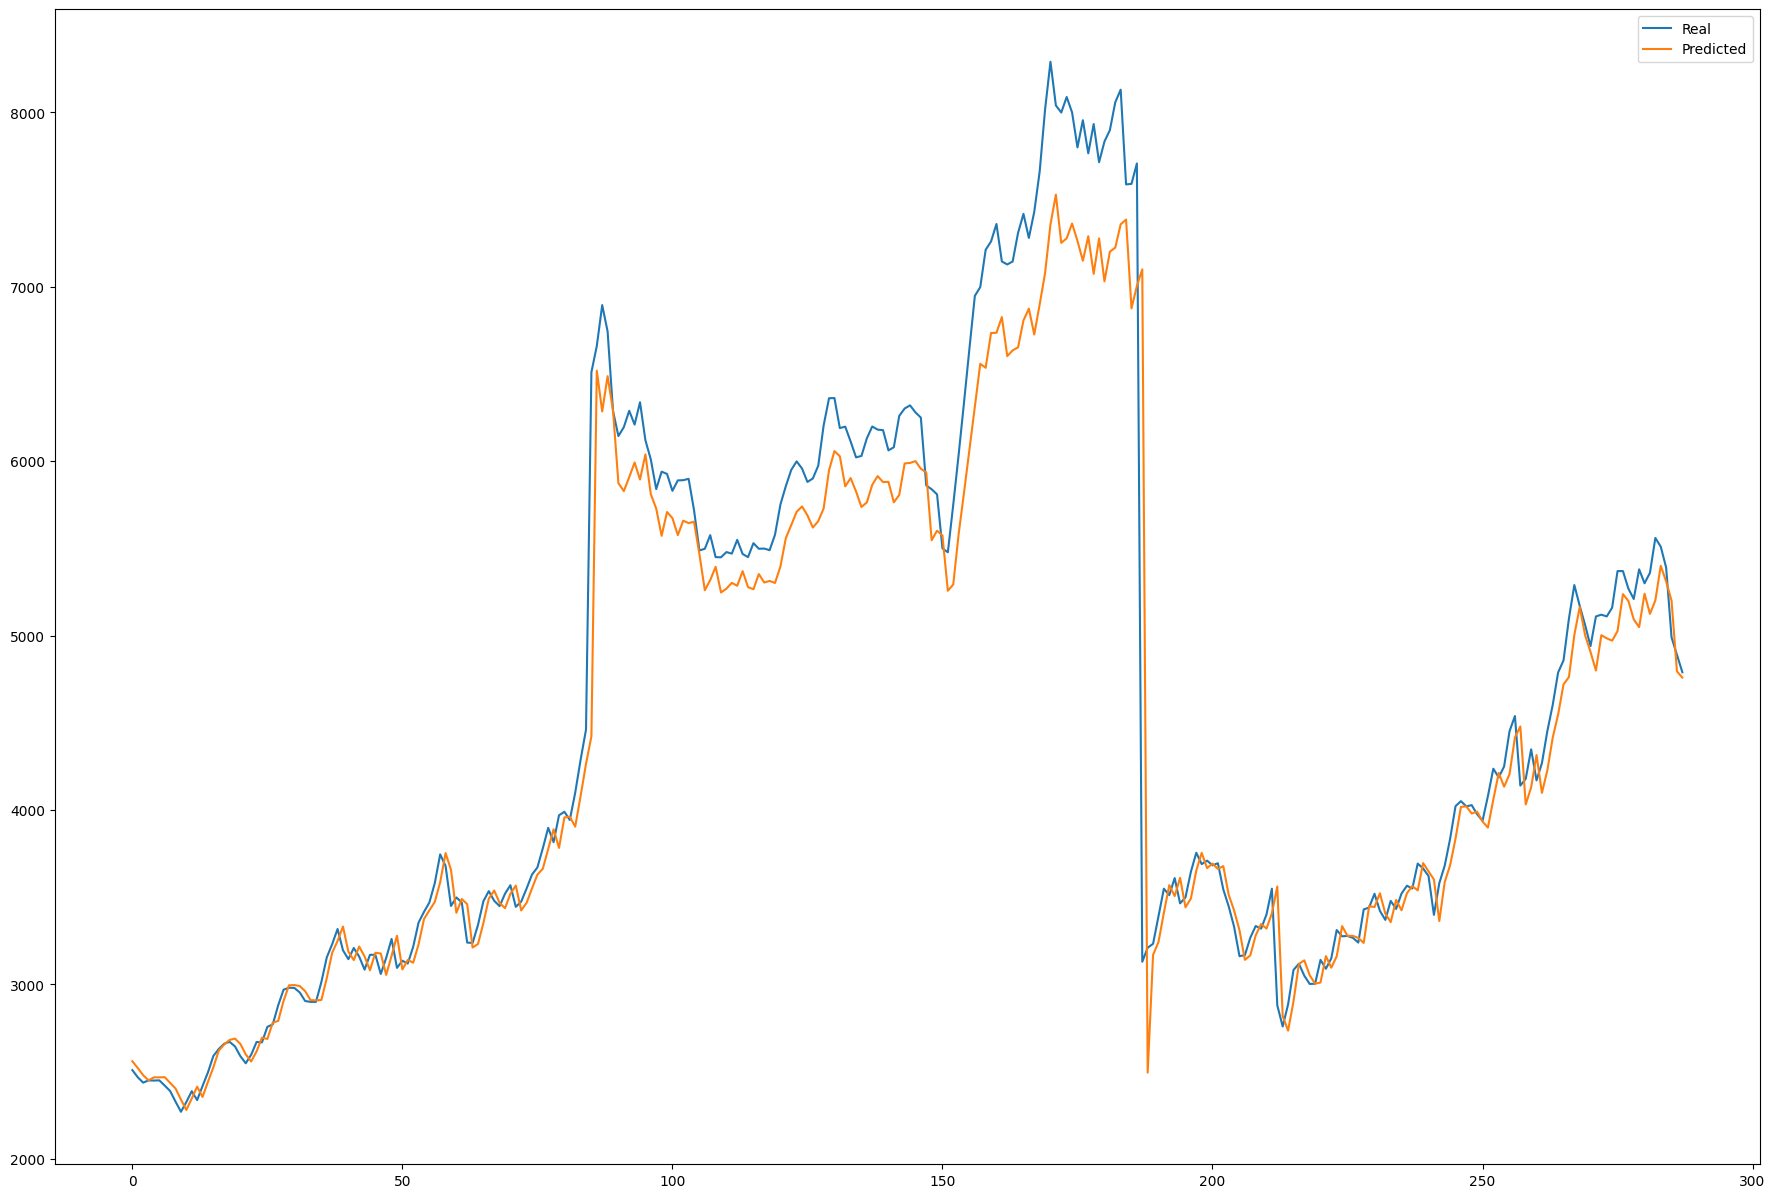

In [19]:
import matplotlib.pyplot as plt
plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(y_test_real[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])

plt.show()



---


# نتیجه گیری

تمامی شبکه‌های عصبی بازگشتی از جمله LSTM، GRU و RNN برای پردازش داده‌های دنباله‌ای استفاده می‌شوند. هر کدام از این شبکه‌ها دارای ویژگی‌های خاصی هستند که در برخی موارد برای پردازش داده‌های دنباله‌ای بهتر از دیگری هستند.

RNN:
شبکه‌ی RNN یکی از ساده‌ترین شبکه‌های عصبی بازگشتی است که در آن اطلاعات از لایه به لایه انتقال پیدا می‌کنند. در این شبکه، در هر گام زمانی، ورودی جدید در کنار ورودی قبلی به لایه ارسال می‌شود و اطلاعات به صورت یکنواخت و بدون انتخاب در طول زمان انتقال پیدا می‌کند. این شبکه در پردازش داده‌های دنباله‌ای کوتاه و بازه‌های زمانی کوتاه به خوبی عمل می‌کند، اما در مواردی که نیاز به حفظ اطلاعات بلندمدت در طول زمان است، با مشکل روبرو می‌شود.

LSTM:
شبکه‌ی LSTM یکی از پیچیده‌ترین شبکه‌های عصبی بازگشتی است که برای حل مشکل ناپدید شدن گرادیان در RNN به وجود آمده است. در این شبکه، سه دروازه‌ی (gate) آموزش‌دیده به نام‌های دروازه باز شدن، دروازه حذف و دروازه خروجی به کار گرفته می‌شود. این دروازه‌ها با کنترل جریان اطلاعات، می‌توانند از ناپدید شدن گرادیان جلوگیری کرده و به خوبی اطلاعات قبلی را در پردازش داده‌های دنباله‌ای استفاده کنند.

GRU:
شبکه‌ی GRU نیز مانند LSTM برای حل مشکل ناپدید شدن گرادیان در RNN به وجود آمده است. در این شبکه به جای سه دروازه در LSTM، فقط دو دروازه باز شدن و حذف وجود دارد. به دلیل تعداد کمتری پارامتر و روند یادگیری سریع‌تر به نسبت LSTM، در برخی موارد سریع‌تر از آن عمل می‌کند.

به طور کلی، هر کدام از این شبکه‌ها دارای ویژگی‌ها و نقاط ضعف و قوت خود هستند و برای مسائل مختلف ممکن است یکی از آن‌ها بهتر عمل کند. اگر در مسئله‌ی مورد نظر نیاز به حفظ اطلاعاتبلندمدت دارید، LSTM یا GRU بهترین گزینه خواهند بود. اما اگر مسئله‌ی شما ساده‌تر است و نیاز به پردازش داده‌های دنباله‌ای کوتاه دارید، RNN ممکن است بهترین گزینه باشد. همچنین، برای مسائل بازیابی اطلاعات از داده‌های دنباله‌ای، شبکه‌های بازگشتی از شبکه‌های پیچشی (CNN) عملکرد بهتری دارند. در نهایت، برای انتخاب بهترین شبکه، باید با توجه به خصوصیات مسئله‌ی مورد نظر و انواع داده‌های ورودی، شبکه‌ی مناسب را انتخاب کرد.

 در این پروژه LSTM بهترین عملکرد را داشت. با این حال، پیش‌بینی با دقت بسیار بالا در بورس تقریبا ناممکن است. این به دلیل وجود عوامل زیادی است که برقراری یک الگوی قابل پیش‌بینی در بازار سهام را تقریبا غیرممکن می‌کند. به عنوان مثال، عوامل اقتصادی، سیاسی، اجتماعی و فنی که می‌توانند بر بازار سهام تأثیر بگذارند، به سختی قابل پیش‌بینی هستند. به همین دلیل، پیش‌بینی به دقت بسیار بالا در بورس تقریبا ناممکن است و تنها می‌توان به دقتی محدود رسید.